<div class="alert alert-block alert-info">
<b>Deadline:</b> April 26, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Recurrent relational network

The goal of this exercise is to get familiar with graph neural networks.

We will implement a simplified version of the recurrent relational network proposed in [this paper](http://papers.nips.cc/paper/7597-recurrent-relational-networks.pdf).

We recommend you to use a machine with GPU for solving this exercise. Training on CPU will take much longer.

In [24]:
skip_training = True  # Set this flag to True before validation and submission

In [25]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [26]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tools
import tests

In [27]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [28]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [29]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

The dataset is a set of sudoku puzzles with solutions obtained from [here](https://github.com/locuslab/SATNet).

In [30]:
import data
trainset = data.Sudoku(data_dir, train=True)
testset = data.Sudoku(data_dir, train=False)

x, y = trainset[0]
print(x.shape, y.shape)

torch.Size([81, 9]) torch.Size([81])


We can visualize the data in the following way.

In [31]:
def sudoku_to_labels(x):
    """Convert one-hot coded sudoku puzzles to labels. -1 corresponds to missing labels.
    
    Args:
      x of shape (n_rows=9, n_colums=9, n_digits=9): Tensor with a sudoku board. The digits are one-hot coded.
                  Cells with unknown digits have all zeros along the third dimension.
    """
    assert x.shape == torch.Size([9, 9, 9]), "Wrong shape {}".format(x.shape)
    is_filled = x.sum(dim=2)
    y = x.argmax(dim=2)
    y[~is_filled.bool()] = -1
    return y

In [32]:
print(sudoku_to_labels(x.view(9, 9, 9)))

tensor([[ 5,  6, -1, -1, -1, -1, -1, -1,  4],
        [-1, -1,  2, -1,  3, -1, -1,  7,  1],
        [-1,  3, -1, -1, -1,  4,  0,  2,  5],
        [-1, -1, -1,  6,  2, -1, -1,  8, -1],
        [ 2, -1,  3,  1, -1,  5, -1,  6, -1],
        [-1, -1,  0, -1,  8, -1,  5, -1, -1],
        [ 4, -1,  8, -1, -1,  7, -1, -1, -1],
        [-1, -1, -1,  8,  4, -1,  1, -1,  7],
        [-1, -1, -1,  0,  1,  6,  3, -1, -1]])


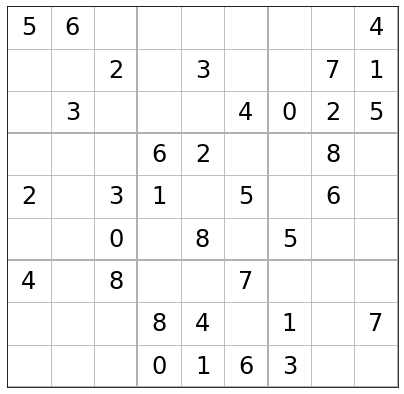

In [33]:
tools.draw_sudoku(x.view(9, 9, 9), logits=False)

## Graph

We describe each sudoku puzzle as a graph in which each node corresponds to one of the 9*9=81 cells in the puzzle. Each node is connected to 8+8+8-4=20 other nodes:
* 8 nodes that correspond to other cells in the same row
* 8 nodes that correspond to other cells in the same column
* 8 nodes that correspond to other cells in the same $3\times 3$ box
* 4 cells appear both in a $3\times 3$ box and in the same row or column.

In this exercise, we decribe a graph as a set of edges. Each edge is a pair (`src_id`, `dst_id`) where `src_id` is the id of the source node and `dst_id` is the id of the destination node. In the cell below, your task is to describe such a graph by producing two lists:
* a list of source node ids `src_id` of all edges
* a list of destination node ids `dst_id` of all edges

Notes:

* To be consistent with the training data set, we need to use node ids from 0 and 80 according to the following order:
```
[ 0,  1,  2,  3,  4,  5,  6,  7,  8]
[ 9, 10, 11, 12, 13, 14, 15, 16, 17]
[18, 19, 20, 21, 22, 23, 24, 25, 26]
[27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44]
[45, 46, 47, 48, 49, 50, 51, 52, 53]
[54, 55, 56, 57, 58, 59, 60, 61, 62]
[63, 64, 65, 66, 67, 68, 69, 70, 71]
[72, 73, 74, 75, 76, 77, 78, 79, 80]
```
* This function is called only once before training. Therefore, you do not need to optimize its execution time.

In [34]:
def sudoku_edges():
    """Generate edges of the graph describing the sudoku puzzle.
    
    Returns:
      src_ids: LongTensor of length 1620 with source node ids of all the edges in the graph.
      dst_ids: LongTensor of length 1620 with destination node ids of all the edges in the graph
    
    Note: Our tests assume that node ids are between 0 and 80. Please follow this convention.
    """
    # YOUR CODE HERE
    field = torch.arange(81, dtype=torch.long).view(9,9)
    src_ids = torch.zeros(20,dtype=torch.long)
    br = bc = r = c = 0
    dst_ids = torch.unique(torch.cat((field[r], field[:,c] , field[br:br+3,bc:bc+3].flatten())))
    dst_ids = dst_ids[dst_ids != 0]
    for r in range(9):
        for c in range(9):
            i = (r*9+c)
            br = int(r/3)*3
            bc = int(c/3)*3
            if i == 0: continue
            src_ids = torch.cat((src_ids, torch.ones(20,dtype=torch.long)*i),0)
            new_dst = torch.unique(torch.cat((field[r], field[:,c] , field[br:br+3,bc:bc+3].flatten() ),0))
            new_dst = new_dst[new_dst!=i] 
            dst_ids = torch.cat((dst_ids, new_dst),0)
    return src_ids, dst_ids
    # Commented by myself - raise NotImplementedError()

In [35]:
sudoku_src_ids, sudoku_dst_ids = sudoku_edges()
print('Number of edges in each sudoku graph: %d' % len(sudoku_src_ids))
assert sudoku_src_ids.dtype == torch.long and sudoku_dst_ids.dtype == torch.long
assert len(sudoku_src_ids) == len(sudoku_dst_ids), "The number of source and destination nodes should be same."
assert len(sudoku_src_ids) == 1620, "Wrong number of edges ({}), expected: 1620".format(len(sudoku_src_ids))
assert min(sudoku_src_ids) == 0 and max(sudoku_src_ids) == 80, "Node ids should be between 0 and 80"
assert min(sudoku_dst_ids) == 0 and max(sudoku_dst_ids) == 80, "Node ids should be between 0 and 80"

Number of edges in each sudoku graph: 1620


## Custom data loader

We first create a custom data loader to process a mini-batch of graphs (in parallel) to compute the derivatives wrt the parameters of the graph neural network. To do that, **we transform a mini-batch of graphs to one large graph without interconnecting edges between the subgraphs corresponding to individual examples in the mini-batch.** We do this using a custom collate function that you need to implement in the cell below.

In [36]:
def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (inputs, targets),
          inputs of shape (n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
              in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
          targets of shape (n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).

    Returns:
      inputs of shape (batch_size*n_nodes, 9): Inputs to each node in the graph. Inputs are one-hot coded digits
          in the sudoku puzzle. A missing digit is encoded with all zeros. n_nodes=81 for the sudoku graph.
      targets of shape (batch_size*n_nodes): A LongTensor of targets (correct digits in the sudoku puzzle).
      src_ids of shape (batch_size*1620): LongTensor of source node ids for each edge in the large graph.
          The source ids should be between 0 and batch_size * 81.
      dst_ids of shape (batch_size*1620): LongTensor of destination node ids for each edge in the large graph.
          The destination ids should be between 0 and batch_size * 81.
    """
    # YOUR CODE HERE
    inputs ,targets = zip(*list_of_samples)
    bs = len(inputs)
    inputs = torch.cat(inputs,0)
    targets = torch.cat(targets,0)
    s_ids, d_ids = sudoku_edges()
    src_ids, dst_ids = s_ids.clone(), d_ids.clone()
    for i in range(1,bs):
        src_ids = torch.cat((src_ids,i*81+s_ids),0)
        dst_ids = torch.cat((dst_ids,i*81+d_ids),0)
    return inputs, targets, src_ids, dst_ids
    # Commented by myself - raise NotImplementedError()

In [37]:
def test_collate_shapes():
    batch_size = 2
    n_nodes = 81
    inputs, targets, src_ids, dst_ids = collate([trainset[0], trainset[1]])
    assert inputs.shape == torch.Size([batch_size*n_nodes, 9]), f"Bad inputs.shape: {inputs.shape}"
    assert targets.shape == torch.Size([batch_size*n_nodes]), f"Bad targets.shape: {targets.shape}"
    assert src_ids.shape == torch.Size([batch_size*1620]), f"Bad src_ids.shape: {src_ids.shape}"
    assert dst_ids.shape == torch.Size([batch_size*1620]), f"Bad dst_ids.shape: {dst_ids.shape}"
    assert min(src_ids) == 0 and max(src_ids) == batch_size*81-1
    assert min(dst_ids) == 0 and max(dst_ids) == batch_size*81-1
    print('Success')

test_collate_shapes()

Success


In [38]:
trainloader = DataLoader(trainset, batch_size=16, collate_fn=collate, shuffle=True)
testloader = DataLoader(testset, batch_size=16, collate_fn=collate, shuffle=False)

<img src="recurrent_rn.png" width=300 style="float: right;">

# Graph neural network

You need to implement a graph neural network in the cell below. Its forward function consists of `n_iters` iterations with the following steps:
* For each node, compute the messages from all its neighbors using the message network (see description below).
* For each destination node, aggregate (by summation) all the messages sent by its neighbors. You may find it useful to use function [index_add_](https://pytorch.org/docs/stable/generated/torch.Tensor.index_add_.html#torch.Tensor.index_add_) for that.
* The aggregated messages are concatenated with the node inputs to form the inputs of the gated recurrent units (GRUs) whose states represent the states of the nodes. The node inputs are one-hot coded digits 1-9 of the sudoku puzzle, a missing digit is encoded with all zeros. 
* The states of the GRUs are updated using the standard GRU computations.
* The states of each graph node are linearly combined to compute the output of the corresponding node at the current iteration.

**Note that since we combine all graphs in the mini-batch into a single graph using `collate()` function, we do not need to care about batches in our implementation of GNN.**


### Message network

* All messages are computed with the same message network (shared parameters).
* The message network takes as inputs the states of the source node and the states of the destination node and produces a vector with `n_edge_features`.
* We used as the message network a multilayer perceptron (MLP) network with the following architecture:
  * hidden layer with 96 neurons and ReLU nonlinearity
  * hidden layer with 96 neurons and ReLU nonlinearity
  * output layer with `n_edge_features` output features.
* **Important:** Our tests assume that the message network is defined as an attribute called `msg_net`, that is it can be accessed as follows:
```
gnn = GNN()
print(gnn.msg_net)
```

Notes:

* Please initialize the node states (before the first iteration) with all zeros.
* The messages computed in the first iteration are not informative because they combine zero states.
* For faster training, try to minimize the number of for-loops in your implementation.
* **Your implementation of the GNN should work with any graph topologies, not necessarily sudoku. Please do not assume any dimensions specific to the sudoku graph.**

In [39]:
class GNN(nn.Module):
    def __init__(self, n_iters=7, n_node_features=10, n_node_inputs=9, n_edge_features=11, n_node_outputs=9):
        """
        Args:
          n_iters: Number of graph iterations.
          n_node_features: Number of features in the states of each node.
          n_node_inputs: Number of inputs to each graph node (on each graph iteration).
          n_edge_features: Number of features in the messages sent along the edges of the graph (produced
              by the message network).
          n_node_outputs: Number of outputs produced by at each node of the graph.
        """
        super(GNN, self).__init__()
        
        self.n_iters = n_iters
        self.n_node_features = n_node_features
        self.n_node_inputs = n_node_inputs
        self.n_edge_features = n_edge_features
        self.n_node_outputs = n_node_outputs
        
        # YOUR CODE HERE
        super(GNN, self).__init__()

        self.n_iters = n_iters
        self.n_node_features = n_node_features
        self.n_node_inputs = n_node_inputs
        self.n_edge_features = n_edge_features
        self.n_node_outputs = n_node_outputs

        # YOUR CODE HERE
        self.pre_net = nn.Linear(n_node_inputs, self.n_node_features)
        # self.embedding = nn.Embedding(self.n_node_inputs,self.n_node_features)
        self.msg_net = nn.Sequential(
            nn.Linear(2 * self.n_node_features, 96),
            nn.ReLU(),
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, self.n_edge_features),
        )
        self.gru_1 = nn.GRUCell(2 * self.n_node_features, self.n_node_features)
        self.out_net = nn.Linear(self.n_node_features, self.n_node_outputs)
        # Commented by myself - raise NotImplementedError()

    def forward(self, node_inputs, src_ids, dst_ids):
        """
        Args:
          node_inputs of shape (n_nodes, n_node_inputs): Tensor of inputs to every node of the graph.
          src_ids of shape (n_edges): Indices of source nodes of every edge.
          dst_ids of shape (n_edges): Indices of destination nodes of every edge.
          
        Returns:
          outputs of shape (n_iters, n_nodes, n_node_outputs): Outputs of all the nodes at every iteration of the
              graph neural network.
        """
        # YOUR CODE HERE
        n_nodes = node_inputs.size(0)
        outputs = torch.zeros((self.n_iters, n_nodes, self.n_node_outputs), dtype=torch.float,
                              device=node_inputs.device)

        x = self.pre_net(node_inputs)
        hidden = torch.zeros((n_nodes, self.n_node_features)).to(node_inputs.device)
        for iter in range(self.n_iters):
            edges = torch.cat((x[src_ids], x[dst_ids]), 1)  # (edges, 2*features)
            edge_features = self.msg_net(edges)  # (edges, edge_features)

            edge_messages = torch.zeros((n_nodes, self.n_edge_features), device=node_inputs.device)
            received_messages = edge_messages.index_add(0, dst_ids, edge_features)  # (nodes, edge_features)

            inputs = torch.cat((node_inputs, received_messages), dim=1)
            hidden = self.gru_1(inputs, hidden)
            x = hidden.clone()
            outputs[iter] = self.out_net(hidden)
        return outputs
        # Commented by myself - raise NotImplementedError()

In [40]:
# Shape tests of the message network
def test_GNN_msg_net():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81
    n_edges = len(src_ids)
    n_node_features = 5
    n_edge_features = 6

    gnn = GNN(n_iters=7, n_node_features=n_node_features, n_edge_features=n_edge_features)
    msg_net_inputs = torch.zeros(n_edges, 2*n_node_features)
    assert hasattr(gnn, 'msg_net'), "Cannot find the message network."
    messages = gnn.msg_net(msg_net_inputs)  # [n_edges, n_edge_features]
    assert messages.shape == torch.Size([n_edges, n_edge_features]), f"Bad messages.shape: {messages.shape}"
    print('Success')

test_GNN_msg_net()

Success


In [41]:
# Shape tests
def test_GNN_shape():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81

    gnn = GNN(n_iters=7)
    node_inputs = torch.zeros([n_nodes, 9])
    outputs = gnn(node_inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
    assert outputs.shape == torch.Size([gnn.n_iters, n_nodes, 9]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_GNN_shape()

Success


In [42]:
# Test of GNN.forward()
def test_GNN_forward(GNN):
    with torch.no_grad():
        src_ids = torch.LongTensor([0, 1, 0])
        dst_ids = torch.LongTensor([1, 2, 2])
        n_edges = len(src_ids)

        gnn = GNN(n_iters=2, n_node_inputs=1, n_node_features=2, n_edge_features=3, n_node_outputs=2)
        class MyMsgNet(nn.Module):
            def forward(self, msg_net_inputs):
                shape = list(msg_net_inputs.size())
                shape[-1] = gnn.n_edge_features
                messages = torch.ones(*shape)
                return messages
        if isinstance(gnn.msg_net, nn.Module):
            gnn.msg_net = nn.Sequential(MyMsgNet())
            # nn.Sequential() is to handle a for loop over msg_net layers :)
        else:
            gnn.msg_net = lambda x: MyMsgNet.forward(None, x)
        
        def set_weights(gnn):
            for name, module in gnn.named_modules():
                if isinstance(module, (nn.GRU, nn.GRUCell)):
                    if isinstance(module, nn.GRU):
                        weight_ih = module.weight_ih_l0
                        weight_hh = module.weight_hh_l0
                    else:
                        weight_ih = module.weight_ih
                        weight_hh = module.weight_hh
                    
                    weight_ih.data.fill_(0)
                    weight_ih.data[:2, :].fill_(0.1)   # reset
                    weight_ih.data[2:4, :].fill_(0.1)  # update
                    weight_ih.data[4:, :].fill_(1)   # new value
                    # Since the weights are all equal, we do not need to care about the order of the inputs

                    weight_hh.data.fill_(0)
                    weight_hh.data[1, :].fill_(0.1)   # reset
                    weight_hh.data[2, :].fill_(-0.1)   # reset
                    weight_hh.data[2:4, 1].fill_(0.1) # update
                    weight_hh.data[4:, 1].fill_(0.1)   # new value
                    
                    if module.bias == True:
                        if isinstance(module, nn.GRU):
                            bias_ih = module.bias_ih_l0
                            bias_hh = module.bias_hh_l0
                        else:
                            bias_ih = module.bias_ih
                            bias_hh = module.bias_hh
                                
                        bias_ih.data.fill_(0)
                        bias_hh.data.fill_(0)

                elif isinstance(module, nn.Linear) and (module.in_features == 2) and (module.out_features == 2):
                    module.weight.data = torch.eye(2)
                    module.bias.data.fill_(0)

        set_weights(gnn)
        node_inputs = torch.Tensor([1, 2, 3]).view(3, 1)
        outputs = gnn.forward(node_inputs, src_ids, dst_ids)  # [n_iters, n_nodes, n_node_outputs]
        expected = torch.tensor([
            [[0.3618, 0.3618],
             [0.3775, 0.3775],
             [0.2891, 0.2891]],
            [[0.5554, 0.5519],
             [0.6125, 0.6070],
             [0.4946, 0.4904]]
        ])
        print('outputs:\n', outputs)
        print('expected:\n', expected)

        assert torch.allclose(outputs, expected, atol=1e-04) or \
               torch.allclose(outputs, F.log_softmax(outputs, dim=-1), atol=1e-04) or \
               torch.allclose(outputs, F.softmax(outputs, dim=-1), atol=1e-04)
        print('Success')
        
test_GNN_forward(GNN)

outputs:
 tensor([[[0.3618, 0.3618],
         [0.3775, 0.3775],
         [0.2891, 0.2891]],

        [[0.5554, 0.5519],
         [0.6125, 0.6070],
         [0.4946, 0.4904]]])
expected:
 tensor([[[0.3618, 0.3618],
         [0.3775, 0.3775],
         [0.2891, 0.2891]],

        [[0.5554, 0.5519],
         [0.6125, 0.6070],
         [0.4946, 0.4904]]])
Success


## Train the network

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* 30 epochs is usually enough for training to converge.
* The loss should be the mean of the classification losses computed at **every** GNN iteration. This way you encourage the GNN to find the correct solution with as few iterations as possible.

Hints:
* The training loss at convergence can reach 0.25. The classification loss computed after the **last** GNN iteration should be close to 0.
* The fraction of solved test puzzles is usually close to 1 (we will use the threshold of 0.93 in the tests).
* We recommend you to track the fraction of solved puzzles in the test set using the function below.

In [43]:
# Create network
gnn = GNN()
gnn.to(device)

GNN(
  (pre_net): Linear(in_features=9, out_features=10, bias=True)
  (msg_net): Sequential(
    (0): Linear(in_features=20, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): ReLU()
    (4): Linear(in_features=96, out_features=11, bias=True)
  )
  (gru_1): GRUCell(20, 10)
  (out_net): Linear(in_features=10, out_features=9, bias=True)
)

In [44]:
def fraction_of_solved_puzzles(gnn, testloader):
    with torch.no_grad():
        n_test = 0
        n_test_solved = 0
        for i, (inputs, targets, src_ids, dst_ids) in enumerate(testloader):
            # inputs is [n_nodes, 9*9, 9]
            # targets is [n_nodes]
            batch_size = inputs.size(0) // 81
            inputs, targets = inputs.to(device), targets.to(device)
            src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

            outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
            solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)

            final_solution = solution[-1].argmax(dim=3)
            solved = (final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1)
            n_test += solved.size(0)
            n_test_solved += solved.sum().item()
            return n_test_solved / n_test

In [45]:
# Implement the training loop here
if not skip_training:
    # YOUR CODE HERE
    optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001)
    n_epochs = 5
    LOSS = []
    for epoch in range(n_epochs):
        l_loss = []
        for i, (inputs, targets, src_ids, dst_ids) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets, src_ids, dst_ids = inputs.to(device), targets.to(device), src_ids.to(device), dst_ids.to(device)
            out = gnn.forward(inputs, src_ids, dst_ids)
            out = out.permute(1,2,0)
            targets = torch.unsqueeze(targets, 1)
            targets = targets.expand(-1, 7)
            loss = F.cross_entropy(out, targets)
            loss.backward()
            l_loss.append(loss.item())
            print(i,len(trainloader),l_loss[-1])
            optimizer.step()
        LOSS.append(np.mean(l_loss))
        print('Loss',epoch,':',LOSS[-1])
        print('Fraction solved:',fraction_of_solved_puzzles(gnn, trainloader))
    # Commented by myself - raise NotImplementedError()

0 563 2.2236146926879883
1 563 2.2091190814971924
2 563 2.2012360095977783
3 563 2.1969470977783203
4 563 2.1922130584716797
5 563 2.1869027614593506
6 563 2.179990768432617
7 563 2.170929193496704
8 563 2.161224126815796
9 563 2.152479410171509
10 563 2.1418378353118896
11 563 2.1280019283294678
12 563 2.1196446418762207
13 563 2.0993337631225586
14 563 2.0931684970855713
15 563 2.0821588039398193
16 563 2.0679454803466797
17 563 2.07358455657959
18 563 2.0559444427490234
19 563 2.0432651042938232
20 563 2.0309107303619385
21 563 2.0236895084381104
22 563 2.011495351791382
23 563 2.001713752746582
24 563 1.9937183856964111
25 563 1.9833402633666992
26 563 1.9753355979919434
27 563 1.965422511100769
28 563 1.9481476545333862
29 563 1.9422084093093872
30 563 1.9256623983383179
31 563 1.9225245714187622
32 563 1.9247463941574097
33 563 1.9038889408111572
34 563 1.8995393514633179
35 563 1.8913416862487793
36 563 1.8917763233184814
37 563 1.878736138343811
38 563 1.8590677976608276
39 563

311 563 1.0967170000076294
312 563 1.0757917165756226
313 563 1.092024803161621
314 563 1.117228627204895
315 563 1.1066827774047852
316 563 1.0902389287948608
317 563 1.0703718662261963
318 563 1.0659406185150146
319 563 1.0685840845108032
320 563 1.0941942930221558
321 563 1.0833324193954468
322 563 1.1120787858963013
323 563 1.0969464778900146
324 563 1.0803730487823486
325 563 1.094994068145752
326 563 1.0766459703445435
327 563 1.0647921562194824
328 563 1.1095064878463745
329 563 1.111749291419983
330 563 1.053577184677124
331 563 1.0871819257736206
332 563 1.0944174528121948
333 563 1.0566692352294922
334 563 1.0629881620407104
335 563 1.058226227760315
336 563 1.1035504341125488
337 563 1.0252857208251953
338 563 1.0532463788986206
339 563 1.0670408010482788
340 563 1.0527594089508057
341 563 1.060178518295288
342 563 1.0246739387512207
343 563 1.0307973623275757
344 563 1.0506142377853394
345 563 1.0686291456222534
346 563 1.0454951524734497
347 563 1.024157166481018
348 563 1

54 563 0.6546810865402222
55 563 0.6482349634170532
56 563 0.6071918606758118
57 563 0.6247900724411011
58 563 0.634950578212738
59 563 0.6211028099060059
60 563 0.63727205991745
61 563 0.6036244630813599
62 563 0.6016175746917725
63 563 0.6154609322547913
64 563 0.6745647192001343
65 563 0.6055066585540771
66 563 0.6397960782051086
67 563 0.6334251165390015
68 563 0.6246994733810425
69 563 0.6364782452583313
70 563 0.6191785931587219
71 563 0.5969549417495728
72 563 0.6109845638275146
73 563 0.6336500644683838
74 563 0.6193517446517944
75 563 0.6351894736289978
76 563 0.6219285130500793
77 563 0.5978637337684631
78 563 0.6583927273750305
79 563 0.5670086741447449
80 563 0.5998599529266357
81 563 0.6447360515594482
82 563 0.6256059408187866
83 563 0.6246700882911682
84 563 0.6063057780265808
85 563 0.5775145888328552
86 563 0.5952060222625732
87 563 0.625163197517395
88 563 0.5801910161972046
89 563 0.5903121829032898
90 563 0.6219318509101868
91 563 0.6103334426879883
92 563 0.6050187

359 563 0.37388375401496887
360 563 0.3684788942337036
361 563 0.3689824044704437
362 563 0.3932308256626129
363 563 0.3866986334323883
364 563 0.37593331933021545
365 563 0.41066521406173706
366 563 0.37710121273994446
367 563 0.41469621658325195
368 563 0.37414854764938354
369 563 0.3460342288017273
370 563 0.3645341396331787
371 563 0.3422502279281616
372 563 0.3787147104740143
373 563 0.37777969241142273
374 563 0.3753524720668793
375 563 0.41065922379493713
376 563 0.37167155742645264
377 563 0.376716673374176
378 563 0.3704816699028015
379 563 0.3581262528896332
380 563 0.33235904574394226
381 563 0.3709512948989868
382 563 0.3640872538089752
383 563 0.3709055185317993
384 563 0.36015596985816956
385 563 0.3638957142829895
386 563 0.3247889578342438
387 563 0.3475549817085266
388 563 0.3805710971355438
389 563 0.36204442381858826
390 563 0.3893023431301117
391 563 0.3529635965824127
392 563 0.39607203006744385
393 563 0.3675997257232666
394 563 0.3522350788116455
395 563 0.347242

98 563 0.267673134803772
99 563 0.2688731253147125
100 563 0.29695555567741394
101 563 0.28336459398269653
102 563 0.2760862410068512
103 563 0.3021889925003052
104 563 0.3185250759124756
105 563 0.2567361891269684
106 563 0.28872886300086975
107 563 0.2728216052055359
108 563 0.2600639760494232
109 563 0.2538670301437378
110 563 0.2855469882488251
111 563 0.2789350152015686
112 563 0.2690761685371399
113 563 0.275068998336792
114 563 0.28325581550598145
115 563 0.2873714566230774
116 563 0.25174766778945923
117 563 0.24561898410320282
118 563 0.25559380650520325
119 563 0.27420589327812195
120 563 0.2695668935775757
121 563 0.23267939686775208
122 563 0.28291818499565125
123 563 0.27726712822914124
124 563 0.26731249690055847
125 563 0.2352718561887741
126 563 0.25990915298461914
127 563 0.29201772809028625
128 563 0.26872751116752625
129 563 0.2576582133769989
130 563 0.2790381908416748
131 563 0.24454906582832336
132 563 0.23017460107803345
133 563 0.2528004050254822
134 563 0.24949

396 563 0.2150420844554901
397 563 0.19285638630390167
398 563 0.19987311959266663
399 563 0.1942615658044815
400 563 0.22906874120235443
401 563 0.1956266313791275
402 563 0.24374452233314514
403 563 0.20413807034492493
404 563 0.2093668282032013
405 563 0.22097671031951904
406 563 0.24317628145217896
407 563 0.20940810441970825
408 563 0.1984827071428299
409 563 0.2242705523967743
410 563 0.2483176290988922
411 563 0.21640034019947052
412 563 0.18204164505004883
413 563 0.2444404512643814
414 563 0.24932049214839935
415 563 0.21268798410892487
416 563 0.1929631233215332
417 563 0.20442207157611847
418 563 0.22213129699230194
419 563 0.2107214778661728
420 563 0.2042606770992279
421 563 0.19202318787574768
422 563 0.1929258108139038
423 563 0.2119775116443634
424 563 0.20274250209331512
425 563 0.19025976955890656
426 563 0.20985768735408783
427 563 0.20827363431453705
428 563 0.20530720055103302
429 563 0.20942917466163635
430 563 0.20338407158851624
431 563 0.20410260558128357
432 5

131 563 0.20854304730892181
132 563 0.1702703982591629
133 563 0.18233095109462738
134 563 0.19107979536056519
135 563 0.17606262862682343
136 563 0.17098373174667358
137 563 0.17080742120742798
138 563 0.17363688349723816
139 563 0.17628081142902374
140 563 0.18510304391384125
141 563 0.18695180118083954
142 563 0.1754974126815796
143 563 0.20365281403064728
144 563 0.20894721150398254
145 563 0.16318631172180176
146 563 0.1790824681520462
147 563 0.17420245707035065
148 563 0.16847918927669525
149 563 0.18127620220184326
150 563 0.17406989634037018
151 563 0.17230448126792908
152 563 0.17652422189712524
153 563 0.18421901762485504
154 563 0.15705177187919617
155 563 0.180364727973938
156 563 0.20277132093906403
157 563 0.17387685179710388
158 563 0.18281704187393188
159 563 0.17875859141349792
160 563 0.179891899228096
161 563 0.1656976044178009
162 563 0.1744205355644226
163 563 0.18232527375221252
164 563 0.19983692467212677
165 563 0.1704031080007553
166 563 0.18510454893112183
16

427 563 0.1468164026737213
428 563 0.16578061878681183
429 563 0.16519658267498016
430 563 0.14714400470256805
431 563 0.14747963845729828
432 563 0.14644567668437958
433 563 0.163284569978714
434 563 0.17205297946929932
435 563 0.1437803953886032
436 563 0.14601044356822968
437 563 0.14830146729946136
438 563 0.1325594186782837
439 563 0.15271736681461334
440 563 0.17620894312858582
441 563 0.16412535309791565
442 563 0.1581198126077652
443 563 0.18393319845199585
444 563 0.15106076002120972
445 563 0.15351763367652893
446 563 0.17617982625961304
447 563 0.15269452333450317
448 563 0.17821873724460602
449 563 0.14626358449459076
450 563 0.1723169982433319
451 563 0.14320531487464905
452 563 0.12470408529043198
453 563 0.17976464331150055
454 563 0.15142861008644104
455 563 0.17778348922729492
456 563 0.1506328284740448
457 563 0.1983150839805603
458 563 0.18610411882400513
459 563 0.16709661483764648
460 563 0.16115346550941467
461 563 0.1830509603023529
462 563 0.21798817813396454
46

162 563 0.1414031833410263
163 563 0.16300901770591736
164 563 0.13453082740306854
165 563 0.1512206494808197
166 563 0.16165173053741455
167 563 0.13229404389858246
168 563 0.13120825588703156
169 563 0.15173383057117462
170 563 0.14388993382453918
171 563 0.13163058459758759
172 563 0.13032427430152893
173 563 0.17711174488067627
174 563 0.14921410381793976
175 563 0.13771717250347137
176 563 0.1696605384349823
177 563 0.1554356962442398
178 563 0.13067428767681122
179 563 0.13058164715766907
180 563 0.136936217546463
181 563 0.1553063839673996
182 563 0.14434655010700226
183 563 0.15640880167484283
184 563 0.14334024488925934
185 563 0.15011978149414062
186 563 0.13087990880012512
187 563 0.1333216279745102
188 563 0.1379304975271225
189 563 0.15507365763187408
190 563 0.16950146853923798
191 563 0.15277397632598877
192 563 0.16244201362133026
193 563 0.1430850774049759
194 563 0.13836413621902466
195 563 0.15606655180454254
196 563 0.16488423943519592
197 563 0.1158914715051651
198

458 563 0.13424396514892578
459 563 0.1375042051076889
460 563 0.15571461617946625
461 563 0.13441060483455658
462 563 0.12095671892166138
463 563 0.1186884418129921
464 563 0.15122440457344055
465 563 0.1270834058523178
466 563 0.11875800043344498
467 563 0.15872466564178467
468 563 0.14218628406524658
469 563 0.138143852353096
470 563 0.12457021325826645
471 563 0.12870967388153076
472 563 0.10784732550382614
473 563 0.12658876180648804
474 563 0.13310520350933075
475 563 0.1405157893896103
476 563 0.12078907340765
477 563 0.1537669152021408
478 563 0.140101820230484
479 563 0.1279773861169815
480 563 0.13036955893039703
481 563 0.15891022980213165
482 563 0.12505021691322327
483 563 0.13907593488693237
484 563 0.13437432050704956
485 563 0.14996236562728882
486 563 0.1401928961277008
487 563 0.13532139360904694
488 563 0.11464590579271317
489 563 0.16066929697990417
490 563 0.14613838493824005
491 563 0.15448227524757385
492 563 0.12652766704559326
493 563 0.11780058592557907
494 56

In [46]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(gnn, '1_gnn.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_gnn.pth.


In [47]:
if skip_training:
    gnn = GNN()
    tools.load_model(gnn, '1_gnn.pth', device)

## Evaluate the trained model

In [48]:
# Get graph iterations for some test puzzles
with torch.no_grad():
    inputs, targets, src_ids, dst_ids = next(iter(testloader))
    inputs, targets = inputs.to(device), targets.to(device)
    src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

    batch_size = inputs.size(0) // 81
    outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, n_nodes, 9]

    solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)
    final_solution = solution[-1].argmax(dim=3)
    print('Solved puzzles in the current mini-batch:')
    print((final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1))

Solved puzzles in the current mini-batch:
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True])


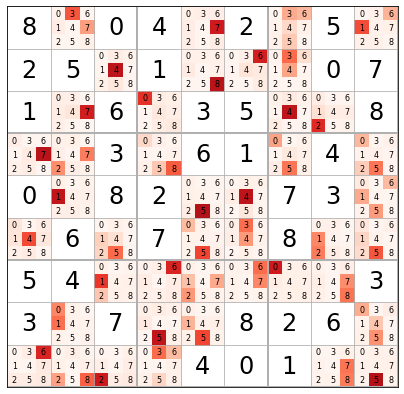

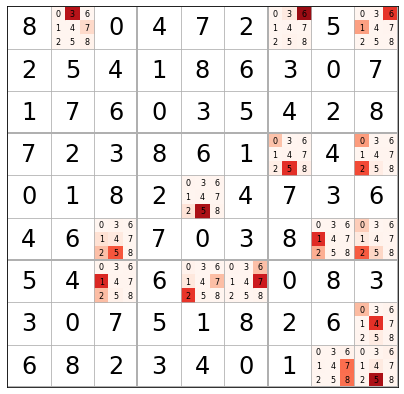

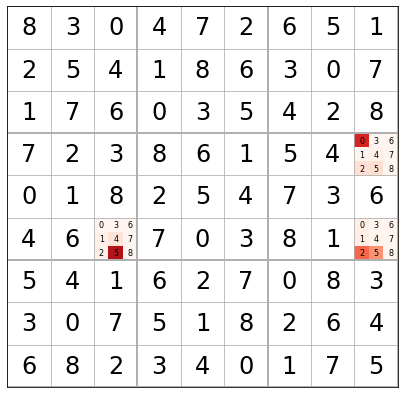

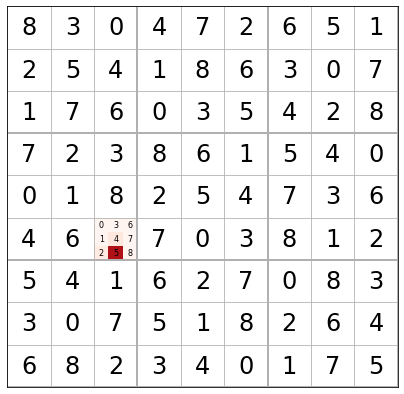

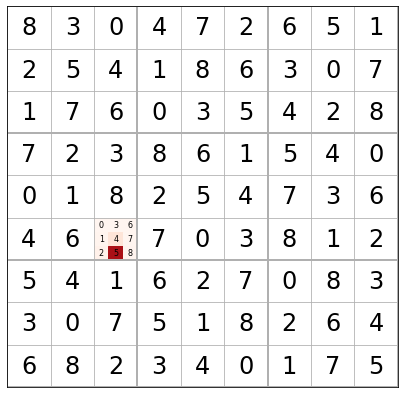

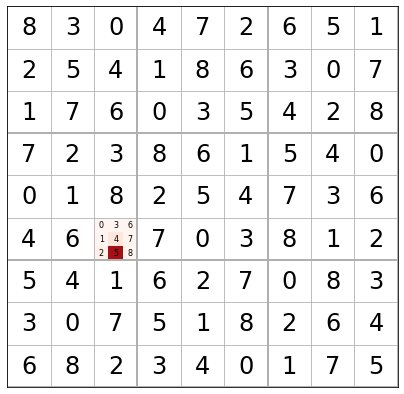

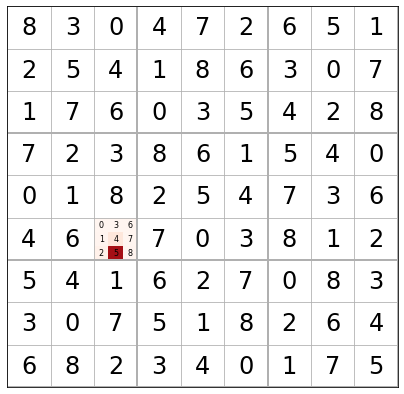

In [49]:
# Visualize graph iteration for one of the puzzles
ix = 0
for i in range(gnn.n_iters):
    tools.draw_sudoku(solution[i, 0], logits=True)

In [50]:
fraction_solved = fraction_of_solved_puzzles(gnn, testloader)
print(fraction_solved)
assert fraction_solved > .93, "Poor accuracy ({:.3f})".format(fraction_solved)
print('Success')

0.9375
Success


<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

In this exercise, we learned how to train a simple graph neural network.

Note that the network learned to solve Sudoku puzzles without being explicitly told about the rules of the game. It learned to solve the puzzle from the training examples. We helped the network by telling which objects (cells) are related to each other but we did not specify the exact type of the relations.